# Demo Data Generation for Nested Accounts (Correspondent Banking) AML Alerts
This notebook simulates customer-month aggregates and computes features for AML alert scenarios in the correspondent banking domain. It covers the following:
| Feature type                  | Feature description                                                                 | Variable in df_agg               | Triggering feature? |
|-------------------------------|-------------------------------------------------------------------------------------|----------------------------------|---------------------|
| Spike in Overall Activity     | Significant increase in total number of transactions compared to the customer’s baseline. | overall_activity_spike           | Yes                 |
| Not Seen BIC                  | A new bank (BIC) appearing in the full path that has not been seen in the past XX months | to be created                    | Yes                 |
| Not Seen Currency             | A new currency appearing in the full path that has not been seen in the past XX months | to be created                    | Yes                 |
| High Risk Jurisdictions       | Unusual value of transactions to high risk jurisdictions (incoming and outgoing).    | to be created                    | Yes                 |
| Round Amount ratio (corporates) | Excessive round amount ratio (e.g., multiples of 1000).                            | to be created                    | Yes                 |
| Pipe Account Behavior Score   | Score representing alternating IN/OUT transaction pattern. High values may indicate pass-through accounts. | pipe_account_behaviour_score     | No                  |
| Many to One                   | Count of unique counterparties that send to the same customer.                       | many_to_one                      | No                  |



### Init Context

In [1]:
from thetaray.api.context import init_context
from thetaray.common.data_environment import DataEnvironment
import datetime
import yaml

import logging
logging.basicConfig(level=logging.DEBUG, format='%(message)s')

with open('/thetaray/git/solutions/domains/demo_nested_banking/config/spark_config.yaml') as spark_config_file:
    spark_config = yaml.load(spark_config_file, yaml.FullLoader)['spark_config_a']
context = init_context(execution_date=datetime.datetime(1970, 1, 1),
                       spark_conf=spark_config,
                       spark_master='local[*]', delete_unused_columns=True, 
                       allow_type_changes=True,
                       )

/thetaray/venv/lib64/python3.11/site-packages/starlette/config.py:60: UserWarning: Config file '.env' not found.
  warnings.warn(f"Config file '{env_file}' not found.")
/thetaray/venv/lib64/python3.11/site-packages/starlette/config.py:60: UserWarning: Config file '.env' not found.
  warnings.warn(f"Config file '{env_file}' not found.")
2025-08-27 17:51:59,850:INFO:thetaray.common.logging:start loading solution.....[ load_risks=True , solution_path=/thetaray/git/solutions/domains , settings_path=/thetaray/git/solutions/settings ]
2025-08-27 17:51:59,860:WARNING:thetaray.common.logging:Encryption is enabled on dataset demo_human_trafficking_insights, but data encryption is disabled in deployment
2025-08-27 17:51:59,875:WARNING:thetaray.common.logging:Encryption is enabled on dataset demo_remittance_customer_insights, but data encryption is disabled in deployment
2025-08-27 17:51:59,885:WARNING:thetaray.common.logging:Encryption is enabled on dataset demo_ret_smb_customer_insights, but da

Added `alias` successfully.


2025-08-27 17:52:40,071:INFO:thetaray.common.logging:=== Finished updating schema for Evaluation Flows on Minio ===


Added `alias` successfully.


### Imports

In [2]:
from thetaray.api.dataset import dataset_functions

from domains.demo_nested_banking.datasets.customer_monthly import customer_monthly_dataset
from domains.demo_nested_banking.datasets.customers import customers_dataset
from domains.demo_nested_banking.datasets.transactions import transactions_dataset

from pyspark.sql import functions as f

import logging
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import random
from faker import Faker
import uuid

faker = Faker()

### Data Generation

In [3]:
# ---------------- Config ----------------
NUM_RESPONDENTS = 100               # number of respondent customers (nested accounts)
NUM_MONTHS = 8                      # months of history
ANOM_RESPONDENT = "RESP_999"        # the anomalous customer
ANOM_NAME = "Bank Trust Ltd."
ANOM_SPIKE_MONTH_IDX = -1           # last month → strong anomaly
ANOM_PRECURSOR_MONTH_IDX = -3       # earlier month → mild anomaly
SEED = 42

random.seed(SEED)
np.random.seed(SEED)

# Size/amount regimes for respondents
# only one for facilitating modelling
TYPE_CONFIG = {
    #'Small':  {'min_txn': 350,  'max_txn': 600,  'avg_amount': (15_000, 120_000)},
    'Medium': {'min_txn': 800,  'max_txn': 1500, 'avg_amount': (40_000, 350_000)},
    #'Large':  {'min_txn': 1800, 'max_txn': 3200, 'avg_amount': (75_000, 1_100_000)},
}
#TYPE_BUCKETS = ['Small'] * 50 + ['Medium'] * 30 + ['Large'] * 20
TYPE_BUCKETS = ['Medium'] * 100

# Countries & risk (demo lists; adjust to your policy)
COUNTRIES = [
    ('US','United States'), ('GB','United Kingdom'), ('DE','Germany'), ('FR','France'),
    ('NL','Netherlands'), ('CH','Switzerland'), ('SE','Sweden'), ('AE','United Arab Emirates'),
    ('CN','China'), ('IN','India'), ('MX','Mexico'), ('BR','Brazil'), ('ZA','South Africa'),
    ('SG','Singapore'), ('HK','Hong Kong'), ('AU','Australia'), ('JP','Japan'), ('CA','Canada')
]
HIGH_RISK = [('NG','Nigeria'), ('IR','Iran'), ('CU','Cuba'), ('SY','Syria'), ('RU','Russia')]

# Currencies (normal vs rare to trigger "Not Seen Currency")
NORMAL_CCYS = ['USD','EUR','GBP','CHF','SEK','CAD','JPY','AUD','SGD','HKD','AED','CNY','INR']
RARE_CCYS   = ['KZT','UZS','GHS','RSD','UAH','CLP','COP','NGN']

# ISO 20022 message definitions (MX only)
MX_MESSAGES = [
    # (message_name, purpose)
    ('pacs.008.001.10', 'CustomerCreditTransfer'),
    ('pacs.009.001.10', 'FItoFITransfer'),   # CORE/COV variants not modeled separately, but you can add if needed
]

# ISO 20022 charge bearer codes
CHARGE_BEARERS = ['SLEV', 'SHAR', 'DEBT', 'CRED']

# Channels (for completeness; SWIFT CBPR+ rail)
CHANNELS = ['SWIFT-CBPR+']

In [6]:
# ---------------- ISO 20022 (MX) NESTED/CORRESPONDENT TRANSACTION GENERATOR ----------------
# Produces SWIFT CBPR+-style MX payments (pacs.008 / pacs.009) for nested accounts.
# Triggers injected: Spike in Activity, Not Seen BIC, Not Seen Currency, High Risk Jurisdictions, Round Amount ratio.

# ------------------------ HELPERS ------------------------
def bic8(b): 
    return b[:8].upper() if isinstance(b, str) else None


def make_bic(country_code: str) -> str:
    bank = ''.join(random.choice('ABCDEFGHIJKLMNOPQRSTUVWXYZ') for _ in range(4))
    loc  = ''.join(random.choice('ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789') for _ in range(2))
    branch = ''.join(random.choice('ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789') for _ in range(3))
    if random.random() < 0.6:
        return f"{bank}{country_code}{loc}"
    return f"{bank}{country_code}{loc}{branch}"


def pick_country(high_risk=False):
    return random.choice(HIGH_RISK if high_risk else COUNTRIES)


def choose_currency(allow_rare=False):
    if allow_rare and random.random() < 0.85:
        return random.choice(RARE_CCYS), True
    return random.choice(NORMAL_CCYS), False


def force_round_thousands(low, high):
    base = random.randint(int(low//1000), int(high//1000)) * 1000
    return float(base), True


def non_round_amount(low, high):
    amt = np.random.uniform(low, high)
    return round(float(amt), 2), False


def choose_mx_message():
    return random.choice(MX_MESSAGES)

# ------------------------ PERSISTENT BIC8 POOLS ------------------------
# customer_id -> {own_bic8, intr_pool_bic8, cdtr_pool_bic8, home_cc, home_cn}
CUSTOMER_BIC_POOLS = {}
COUNTRY_BY_CODE = {cc:nm for cc,nm in COUNTRIES + HIGH_RISK}


def _init_bic_pools(respondents):
    for r in respondents:
        home_cc, home_cn = random.choice(COUNTRIES)
        own = bic8(make_bic(home_cc))
        intr_pool = [bic8(make_bic(random.choice(COUNTRIES)[0])) for _ in range(random.randint(2,5))]
        cdtr_pool = [bic8(make_bic(random.choice(COUNTRIES)[0])) for _ in range(random.randint(4,8))]
        CUSTOMER_BIC_POOLS[r['customer_id']] = {
            'home_cc': home_cc, 'home_cn': home_cn,
            'own_bic8': own,
            'intr_pool_bic8': intr_pool,
            'cdtr_pool_bic8': cdtr_pool,
        }

def _build_agents_for_flags(cust_id, direction, new_intr_bics_this_month=None, force_high_risk=False):
    """
    Devuelve únicamente los ESCALARES necesarios (sin arrays en el registro):
    - Países de dbtr/cdtr, BIC8 de agentes dbtr/cdtr
    - Señales derivadas de intermediarios 'inters' (internos, no persistidos)
    - Flags/contadores de BIC nuevo para esta transacción
    """
    p = CUSTOMER_BIC_POOLS[cust_id]

    # Intermediarios internos (NO se guardan en el registro)
    inter_count = random.choice([0,1,1,2])
    inters = random.choices(p['intr_pool_bic8'], k=inter_count)

    # Introducir a veces uno de los BICs 'nuevos del mes' para que aparezca en la ruta
    if new_intr_bics_this_month and random.random() < 0.20:
        nb8 = random.choice(new_intr_bics_this_month)
        inters.insert(random.randint(0, len(inters)), nb8)

    # Creditor agent (posible high-risk)
    if force_high_risk:
        hr_cc, _ = random.choice(HIGH_RISK)
        cdtr_bic8 = bic8(make_bic(hr_cc))
    else:
        cdtr_bic8 = random.choice(p['cdtr_pool_bic8'])

    dbtr_bic8 = p['own_bic8']

    # Derivar países desde BIC8 (pos 4..5)
    def _cc_from_bic8(b8):
        return b8[4:6] if isinstance(b8, str) and len(b8) >= 6 else None

    db_cc = _cc_from_bic8(dbtr_bic8) or p['home_cc']
    cd_cc = _cc_from_bic8(cdtr_bic8) or random.choice(COUNTRIES)[0]

    # ---- Señales escalares de BIC NUEVO (sin arrays) ----
    new_set = set(new_intr_bics_this_month) if new_intr_bics_this_month else set()
    inters_set = set(inters)
    intersection = new_set.intersection(inters_set)

    txn_has_new_intr_bic = len(intersection) > 0
    num_new_intr_bics_in_trx = len(intersection)

    return {
        'dbtr_country_code': db_cc,
        'dbtr_country_name': COUNTRY_BY_CODE.get(db_cc, 'Unknown'),
        'cdtr_country_code': cd_cc,
        'cdtr_country_name': COUNTRY_BY_CODE.get(cd_cc, 'Unknown'),
        'dbtr_agt_bic8': dbtr_bic8,
        'cdtr_agt_bic8': cdtr_bic8,
        'txn_has_new_intr_bic': txn_has_new_intr_bic,
        'num_new_intr_bics_in_trx': num_new_intr_bics_in_trx,
        # NOTA: 'first_new_intr_bic8' lo fijamos fuera, una sola vez por BIC nuevo del mes
    }

# ------------------------ GENERATOR (MX only, NO ARRAYS) ------------------------
def generate_swift_mx_nested_transactions():
    """
    Generador MX (ISO 20022) sin arrays:
    - Reutiliza pools de BIC8 por cliente
    - Eventos mensuales 'new BIC' (Poisson): raros en normales, elevados en mes anómalo
    - Señales escalares por transacción: txn_has_new_intr_bic, num_new_intr_bics_in_trx, first_new_intr_bic8
    """
    respondents = []
    for i in range(NUM_RESPONDENTS - 1):
        base_mu = random.randint(TYPE_CONFIG['Medium']['min_txn'], TYPE_CONFIG['Medium']['max_txn'])
        respondents.append({
            'customer_id': f'RESP_{i:03d}',
            'customer_name': f"{faker.company()} Bank",
            'type': random.choice(TYPE_BUCKETS),
            'nested_account_id': f"NACC-{i:06d}",
            'base_txn_mu': base_mu
        })
    respondents.append({
        'customer_id': ANOM_RESPONDENT,
        'customer_name': ANOM_NAME,
        'type': 'Small',
        'nested_account_id': f"NACC-999999",
        'base_txn_mu': random.randint(TYPE_CONFIG['Medium']['min_txn'], TYPE_CONFIG['Medium']['max_txn'])
    })

    _init_bic_pools(respondents)

    records = []
    today = pd.Timestamp(datetime.today().replace(day=1))
    periods = [today - pd.DateOffset(months=i) for i in range(NUM_MONTHS)]
    logging.info("Started MX (no arrays) records generation for all respondents.")

    for r in respondents:
        cfg = TYPE_CONFIG[r['type']] if r['type'] in TYPE_CONFIG else TYPE_CONFIG['Medium']

        for idx, period in enumerate(reversed(periods)):
            year_month = pd.to_datetime(period.strftime('%Y-%m'), format='%Y-%m')

            # Defaults
            spike_mult = 1.0
            force_rare_ccy = False
            force_high_risk = False
            round_ratio = 0.04
            corp_share = 0.65 if r['type'] in ['Small','Medium'] else 0.4

            # Índices relativos (último y 3º desde el final)
            last_idx = NUM_MONTHS - 1
            third_from_last_idx = NUM_MONTHS - 3
            is_anom_cust = (r['customer_id'] == ANOM_RESPONDENT)
            is_spike_month = (idx == last_idx)
            is_precursor_month = (idx == third_from_last_idx)

            if is_anom_cust and is_spike_month:
                spike_mult = 3.5
                force_rare_ccy = True
                force_high_risk = True
                round_ratio = 0.35
                logging.info(f"[ANOM SPIKE] {r['customer_id']} period={period}")
            elif is_anom_cust and is_precursor_month:
                spike_mult = 1.2
                force_rare_ccy = True
                round_ratio = 0.12
                logging.info(f"[ANOM PRECURSOR] {r['customer_id']} period={period}")

            # Volumen mensual: baseline estable + ruido leve, y Poisson
            noise_mult = float(np.random.lognormal(mean=0.0, sigma=0.07))
            lam = max(1.0, r['base_txn_mu'] * noise_mult)
            txn_count = int(np.random.poisson(lam) * spike_mult)

            # --- Eventos mensuales de "nuevo BIC" (afecta a intermediarios) ---
            lam_events = 0.15
            if is_anom_cust and is_spike_month:
                lam_events = 5.0
            events = np.random.poisson(lam_events)
            new_intr_bics_this_month = []
            if events > 0:
                for _ in range(events):
                    new_cc = random.choice((COUNTRIES + HIGH_RISK))[0]
                    nb8 = bic8(make_bic(new_cc))
                    CUSTOMER_BIC_POOLS[r['customer_id']]['intr_pool_bic8'].append(nb8)
                    new_intr_bics_this_month.append(nb8)

            # Marcas de primera aparición por BIC (para contar "únicos" sin arrays)
            first_mark_remaining = set(new_intr_bics_this_month)

            # Synthetic corporate parties
            corporates = [{"id": f"CPTY-{uuid.uuid4().hex[:10]}", "name": faker.company()} for _ in range(80)]

            # Generar transacciones
            for _ in range(txn_count):
                trx_ts = period + pd.Timedelta(days=random.randint(1, 28),
                                               hours=random.randint(0, 23),
                                               minutes=random.randint(0, 59),
                                               seconds=random.randint(0, 59))
                msg_def_id, purpose = choose_mx_message()
                direction = random.choice(['IN','OUT'])

                # Agentes y flags sin arrays
                agents = _build_agents_for_flags(
                    cust_id=r['customer_id'],
                    direction=direction,
                    new_intr_bics_this_month=new_intr_bics_this_month,
                    force_high_risk=force_high_risk
                )

                # Moneda e importes
                if force_rare_ccy and random.random() < 0.7:
                    ccy, is_rare = choose_currency(allow_rare=True)
                else:
                    ccy, is_rare = choose_currency(allow_rare=False)

                low, high = cfg['avg_amount']
                is_corporate = random.random() < corp_share
                if is_corporate and random.random() < round_ratio:
                    instd_amt, is_round = force_round_thousands(low, high)
                else:
                    instd_amt, is_round = non_round_amount(low, high)

                intrbk_sttlm_amt = instd_amt
                intrbk_sttlm_dt = (trx_ts + pd.Timedelta(days=random.choice([0,1,1,2]))).date()
                value_dt = (trx_ts + pd.Timedelta(days=random.choice([0,1,1,2]))).date()

                # Partes
                orig = random.choice(corporates)
                benf = random.choice(corporates)

                # ISO IDs
                biz_msg_idr = f"BIZ-{uuid.uuid4()}"
                end_to_end_id = f"E2E-{uuid.uuid4()}"
                tx_id = f"TX-{uuid.uuid4()}"
                instr_id = f"INSTR-{uuid.uuid4()}"
                uetr = str(uuid.uuid4())
                chrg_br = random.choice(CHARGE_BEARERS)
                channel = random.choice(CHANNELS)

                # Señal de primera aparición (si procede)
                first_new_intr_bic8 = None
                if agents['txn_has_new_intr_bic'] and first_mark_remaining:
                    # si en este trx aparecen BICs nuevos del mes, marca uno que aún no haya sido marcado
                    # (sin arrays, usamos la intersección implícita del builder)
                    # Aproximación: si hay remaining, marcamos el siguiente "pendiente".
                    # Esto es conservador y suficiente para demos.
                    candidate = next(iter(first_mark_remaining), None)
                    if candidate is not None:
                        first_new_intr_bic8 = candidate
                        first_mark_remaining.discard(candidate)

                records.append({
                    # Identities & timing
                    'transaction_id': str(uuid.uuid4()),
                    'biz_msg_idr': biz_msg_idr,
                    'msg_def_id': msg_def_id,
                    'purpose': purpose,
                    'uetr': uetr,
                    'end_to_end_id': end_to_end_id,
                    'tx_id': tx_id,
                    'instr_id': instr_id,
                    'transaction_timestamp': trx_ts,
                    'transaction_date': trx_ts.date(),
                    'year_month': pd.to_datetime(year_month),

                    # Enrichment / nested account context
                    'nested_account_id': r['nested_account_id'],
                    'customer_id': r['customer_id'],
                    'customer_name': r['customer_name'],
                    'customer_size': r['type'],

                    # Amounts & currency
                    'instd_amt': instd_amt,
                    'intr_bk_sttlm_amt': intrbk_sttlm_amt,
                    'ccy': ccy,
                    'intr_bk_sttlm_dt': intrbk_sttlm_dt,
                    'value_date': value_dt,
                    'chrg_br': chrg_br,
                    'channel': channel,
                    'direction': direction,

                    # Jurisdicción y agentes (escalares)
                    'dbtr_country_code': agents['dbtr_country_code'],
                    'dbtr_country_name': agents['dbtr_country_name'],
                    'cdtr_country_code': agents['cdtr_country_code'],
                    'cdtr_country_name': agents['cdtr_country_name'],
                    'dbtr_agt_bic8': agents['dbtr_agt_bic8'],
                    'cdtr_agt_bic8': agents['cdtr_agt_bic8'],

                    # Partes
                    'dbtr_id': orig['id'], 'dbtr_name': orig['name'],
                    'cdtr_id': benf['id'], 'cdtr_name': benf['name'],
                    'originator_is_corporate': is_corporate,
                    'beneficiary_is_corporate': True,

                    # Flags
                    'is_round_amount': is_round,
                    'is_new_currency': is_rare,
                    'touches_high_risk_jurisdiction': agents['cdtr_country_code'] in dict(HIGH_RISK),

                    # === NUEVAS SEÑALES ESCALARES (sustituyen arrays) ===
                    'txn_has_new_intr_bic': agents['txn_has_new_intr_bic'],          # BOOL
                    'num_new_intr_bics_in_trx': agents['num_new_intr_bics_in_trx'],  # INT
                    'first_new_intr_bic8': first_new_intr_bic8,                      # STRING / NULL
                })

    logging.info("Finished generating all MX realistic (no arrays) records.")
    return pd.DataFrame(records)

In [17]:
# ---------------- AGGREGATE FEATURES FOR ISO 20022 (MX) NESTED ACCOUNTS ----------------
# Expects the MX generator columns:
# ['transaction_id','transaction_timestamp','year_month','customer_id','customer_name',
#  'instd_amt','ccy','payment_path_bics','is_new_currency',
#  'touches_high_risk_jurisdiction','is_round_amount','originator_is_corporate',
#  'dbtr_id','cdtr_id','direction', ...]
#
# Outputs one row per (customer_id, year_month) with robust z-scores (median/IQR).


# ------------------------ AGGREGATOR (realistic BIC novelty) ------------------------
def _month_index(ts: pd.Timestamp) -> int:
    ts = pd.Timestamp(ts)
    return ts.year * 12 + ts.month

def _robust_z_median_iqr(window_values, current_value, *, 
                         min_history=6, iqr_floor=0.0, use_log=False):
    arr = np.asarray(window_values, dtype=float)
    if arr.size < min_history:
        return 0.0
    x = float(current_value)
    if use_log:
        arr = np.log1p(arr)
        x = np.log1p(x)
    med = float(np.median(arr))
    q1 = float(np.percentile(arr, 25))
    q3 = float(np.percentile(arr, 75))
    iqr = q3 - q1
    if iqr_floor and iqr < iqr_floor:
        iqr = iqr_floor
    if iqr == 0:
        return 0.0
    return (x - med) / iqr

def aggregate_features_mx(df: pd.DataFrame,
                                    hist_window_months: int = 6,
                                    currency_lookback_months: int = 12) -> pd.DataFrame:
    """
    Agrega por (customer_id, year_month) usando sólo campos escalares.
    - BIC nuevo: a partir de txn_has_new_intr_bic / num_new_intr_bics_in_trx / first_new_intr_bic8
    - Moneda nueva: ventana rolling de 12m por cliente (no requiere columna extra)
    - Z-scores robustos (median/IQR) con guardas
    """
    df = df.copy()
    if 'transaction_timestamp' in df.columns:
        df.sort_values(['customer_id', 'year_month', 'transaction_timestamp'], inplace=True)
    else:
        df.sort_values(['customer_id', 'year_month'], inplace=True)

    # --------- Nuevo currency por cliente con ventana 12m (no persiste campo) ---------
    is_new_ccy_flags = []
    last_seen_ccy = {}  # cust -> { ccy -> month_idx }
    for _, row in df.iterrows():
        cust = row['customer_id']
        ym = pd.Timestamp(row['year_month'])
        curr_idx = _month_index(ym)
        c = row.get('ccy')
        if cust not in last_seen_ccy:
            last_seen_ccy[cust] = {}
        seen_map = last_seen_ccy[cust]
        last_idx = seen_map.get(c, None)
        is_new = (last_idx is None) or ((curr_idx - last_idx) >= currency_lookback_months)
        is_new_ccy_flags.append(is_new)
        # actualizar última vista
        if c is not None:
            seen_map[c] = curr_idx
    df['_is_new_ccy_txn'] = is_new_ccy_flags

    # --------- Agregación mensual ---------
    def _monthly_agg(group):
        # Round amounts (sólo corporates)
        corp_mask = group['originator_is_corporate'] == True
        round_corp = (group.loc[corp_mask, 'is_round_amount'] == True).sum()
        corp_cnt = int(corp_mask.sum())
        round_ratio = round_corp / corp_cnt if corp_cnt > 0 else 0.0

        # Pipe behaviour (alternancia IN/OUT en el mes)
        dirs = group['direction'].astype(str).tolist()
        pipe_score = (sum(1 for i in range(1, len(dirs)) if dirs[i] != dirs[i-1]) / (len(dirs)-1)) if len(dirs) >= 2 else 0.0

        # Many-to-one: distintos originadores
        many_to_one = group['dbtr_id'].nunique()

        # BIC nuevo (sin arrays)
        txn_with_new = int((group.get('txn_has_new_intr_bic', False) == True).sum())
        total_new_occ = int(group.get('num_new_intr_bics_in_trx', 0).sum())
        distinct_new = int(group['first_new_intr_bic8'].dropna().nunique()) if 'first_new_intr_bic8' in group.columns else 0

        return pd.Series({
            'customer_name': group['customer_name'].iloc[0],
            'txn_count': group['transaction_id'].nunique(),
            'total_amt': float(group['instd_amt'].sum()),
            'avg_amt': float(group['instd_amt'].mean()) if len(group) else 0.0,

            'new_currency_count': int(group['_is_new_ccy_txn'].sum()),
            'new_intr_bic_txn_count': txn_with_new,
            'new_intr_bic_count': total_new_occ,
            'new_intr_bic_unique_count': distinct_new,

            'high_risk_count': int((group['touches_high_risk_jurisdiction'] == True).sum()),
            'round_amount_ratio': round_ratio,
            'many_to_one_count': int(many_to_one),
            'pipe_account_behaviour_score': float(pipe_score),
        })

    agg = (
        df.groupby(['customer_id', 'year_month'], as_index=False)
          .apply(_monthly_agg)
          .reset_index(drop=True)
    )
    agg['year_month_str'] = agg['year_month'].dt.strftime('%Y-%m')
    agg.sort_values(['customer_id','year_month'], inplace=True)

    # --------- Z-scores robustos (opcionalmente con log1p donde tiene sentido) ---------
    IQR_FLOOR = {
        # OJO: si use_log=True, el floor está en escala log
        'txn_count': 0.15,
        'total_amt': 0.20,
        'new_currency_count': 1.0,
        'new_intr_bic_txn_count': 1.0,
        'new_intr_bic_count': 1.0,
        'new_intr_bic_unique_count': 1.0,
        'high_risk_count': 1.0,
        'round_amount_ratio': 0.02,
    }
    z_cols = {
        'txn_count': 'z_txn_count',
        'total_amt': 'z_total_amt',
        'new_currency_count': 'z_new_currency_count',
        'new_intr_bic_txn_count': 'z_new_intr_bic_txn_count',
        'new_intr_bic_count': 'z_new_intr_bic_count',
        'new_intr_bic_unique_count': 'z_new_intr_bic_unique_count',
        'high_risk_count': 'z_high_risk_count',
        'round_amount_ratio': 'z_round_amount_ratio',
    }

    rows = []
    for cust, g in agg.groupby('customer_id', sort=False):
        g = g.copy().sort_values('year_month')
        for i in range(len(g)):
            row = g.iloc[i].to_dict()
            hist = g.iloc[max(0, i - hist_window_months):i]
            for src, zname in z_cols.items():
                z = _robust_z_median_iqr(
                    hist[src].values if not hist.empty else [],
                    row[src],
                    min_history=6,
                    iqr_floor=IQR_FLOOR.get(src, 0.0),
                    use_log=(src in ['txn_count','total_amt'])
                )
                row[zname] = z
            rows.append(row)

    out = pd.DataFrame(rows).fillna({
        'avg_amt': 0.0,
        'round_amount_ratio': 0.0,
        'pipe_account_behaviour_score': 0.0,
        'many_to_one_count': 0
    })

    # Orden de columnas coherente con tu dataset mensual
    cols = [
        'customer_id','customer_name','year_month','year_month_str',
        'txn_count','total_amt','avg_amt',
        'new_currency_count',
        'new_intr_bic_txn_count','new_intr_bic_count','new_intr_bic_unique_count',
        'high_risk_count',
        'round_amount_ratio','many_to_one_count','pipe_account_behaviour_score',
        'z_txn_count','z_total_amt','z_new_currency_count',
        'z_new_intr_bic_txn_count','z_new_intr_bic_count','z_new_intr_bic_unique_count',
        'z_high_risk_count','z_round_amount_ratio'
    ]
    present = [c for c in cols if c in out.columns]
    return out[present].sort_values(['customer_id','year_month'])


In [4]:
# ---------------- KYC GENERATION FOR NESTED / CORRESPONDENT BANKING ----------------
def generate_kyc():
    return pd.DataFrame([{
        'customer_id': ANOM_RESPONDENT,
        'customer_name': ANOM_NAME,
        'nested_account_id': 'NACC-999999',
        'registration_id': faker.bothify('REG-FI-#######'),
        'swift_bic': make_bic('US'),   # BIC for the correspondent
        'incorporation_date': faker.date_between(start_date='-50y', end_date='-5y'),
        'license_type': random.choice(['Full Banking License', 'Representative Office', 'EMI']),
        'regulator': random.choice(['OCC', 'Federal Reserve', 'FDIC']),
        'head_office_country_code': 'US',
        'head_office_country_name': 'United States',
        'tax_residence': 'US',
        'jurisdiction_risk_level': 'Low',
        
        # Business profile
        'expected_corr_volumes': "5k-20k payments per month",
        'expected_corr_value': "$50M-250M",
        'corr_network_size': random.randint(30, 120),   # number of correspondents
        'aml_risk_rating': random.randint(2, 8),       # scale e.g. 1–10
        'risk_drivers': random.choice([
            'High number of cross-border corridors',
            'Exposure to high-risk jurisdictions',
            'Large volumes in rare currencies',
            'Complex ownership structure',
            'Use of nested relationships'
        ]),
        
        # Compliance & governance
        'pep_flag': random.choice([False, False, False, True]),
        'sanctions_check_status': random.choice(['Clear', 'Pending Review']),
        'ownership_structure': random.choice([
            'State-Owned Bank', 'Privately Held Bank', 'Publicly Listed Bank'
        ]),
        'ultimate_beneficial_owner': faker.name(),
        'compliance_officer_assigned': faker.name(),
        'kyc_onboarding_date': faker.date_between(start_date='-15y', end_date='-2y'),
        'kyc_last_review_date': faker.date_between(start_date='-2y', end_date='today'),
        'next_review_due': faker.date_between(start_date='today', end_date='+1y'),

        # Additional context useful for analysts
        'nested_relationship_type': random.choice(['Direct Nostro/Vostro', 'Nested', 'Indirect']),
        'expected_transaction_patterns': 'Cross-border FI payments; settlement of client flows',
        'monitoring_notes': 'Subject to enhanced due diligence for USD clearing corridor',
    }])


In [7]:
# ---------------- VISUAL CHECKS ----------------
def plot_checks(transactions_df, variable, aggregation):
    anom_txn = transactions_df[transactions_df.customer_id==ANOM_RESPONDENT]
    normal_txn = transactions_df[transactions_df.customer_id!=ANOM_RESPONDENT]

    plt.figure(figsize=(6, 3))
    normal_txn.groupby(['year_month', 'customer_id'])[variable].agg(aggregation).groupby('year_month').mean().plot(label='Normal Customers (Avg)')
    normal_txn.groupby(['year_month', 'customer_id'])[variable].agg(aggregation).groupby('year_month').max().plot(linestyle='dashed',
                                                                                                                 label='Normal Customers (Max)')
    anom_txn.groupby('year_month')[variable].agg(aggregation).plot(label='Anomalous Customer')
    plt.title(f'Monthly {variable} {aggregation} Distribution')
    plt.legend()
    plt.show()

In [14]:
transactions_df = generate_swift_mx_nested_transactions()
transactions_df.head()

2025-08-27 17:39:56,118:INFO:root:Started MX (no arrays) records generation for all respondents.
2025-08-27 17:40:46,373:INFO:root:[ANOM PRECURSOR] RESP_999 period=2025-06-01 17:39:56.118077
2025-08-27 17:40:46,513:INFO:root:[ANOM SPIKE] RESP_999 period=2025-08-01 17:39:56.118077
2025-08-27 17:40:46,754:INFO:root:Finished generating all MX realistic (no arrays) records.


,transaction_id,biz_msg_idr,msg_def_id,purpose,uetr,end_to_end_id,tx_id,instr_id,transaction_timestamp,transaction_date,...,cdtr_id,cdtr_name,originator_is_corporate,beneficiary_is_corporate,is_round_amount,is_new_currency,touches_high_risk_jurisdiction,txn_has_new_intr_bic,num_new_intr_bics_in_trx,first_new_intr_bic8
0,91c84ad0-ebcf-48a5-9cdf-5f36300c994b,BIZ-7488c9f2-ec92-403a-bd9b-1633d9adfc8b,pacs.009.001.10,FItoFITransfer,b2acf7a4-3b17-4e44-94d8-cf2431949023,E2E-9a1430f0-4652-4085-aed6-7b4d16d5f236,TX-98d3e8f2-f8f0-4465-9565-7668bb3fc312,INSTR-a38e4d31-99be-4aca-8e2b-14cc02b5b313,2025-01-02 22:14:21.118077,2025-01-02,...,CPTY-c4a9cacc5b,"Wade, Ewing and Livingston",True,True,False,False,False,False,0,None
1,687fb688-3b62-419a-b84d-a8924aa1f677,BIZ-c1cc2161-21dd-4b42-8500-4a1d1c31d121,pacs.008.001.10,CustomerCreditTransfer,7671d0ef-a932-429e-9296-417a6159887d,E2E-729b5ef0-8157-4642-b390-bbdc37160c81,TX-a7133544-8c48-4daa-88e9-f458215abdd0,INSTR-2ec8e31a-d2fc-4cae-a8f4-f442599b981f,2025-01-09 07:14:33.118077,2025-01-09,...,CPTY-338c228f2f,Mahoney LLC,True,True,False,False,False,False,0,None
2,91be86a0-2afe-44de-9d53-056202374066,BIZ-a18e68cd-fd2b-427f-b8c0-e1950672fd43,pacs.008.001.10,CustomerCreditTransfer,ba0b30ab-ef90-4504-bb10-e482676e9b10,E2E-3d43525c-23fe-452c-8bda-9a921aef7d0c,TX-f20f4481-765c-49a1-ad32-5c82986210e7,INSTR-a931b636-4efc-49d9-914d-8b89a17c61a5,2025-01-05 00:28:45.118077,2025-01-05,...,CPTY-d0ec32efee,Martinez Inc,False,True,False,False,False,True,1,BGJMGB71
3,feb9a52a-2b00-4d25-a9a4-e23c88a42fa9,BIZ-4441b11e-d4f4-46b4-ba87-e5305d784579,pacs.009.001.10,FItoFITransfer,ff204e34-140a-4824-8e0a-160480dca83e,E2E-013be7e0-cc5c-4c7b-970a-b2bd05fe5ffb,TX-3b85b6d2-7031-4b42-ba21-5c81afd9686f,INSTR-7c6e546a-d3ae-4e8f-bfcf-0ad1f53970da,2025-01-13 16:29:13.118077,2025-01-13,...,CPTY-97b2a3e3f6,Keith PLC,False,True,False,False,False,False,0,None
4,61e344d4-cf8f-4308-b78e-a6286f69dec2,BIZ-8dcb24e1-5e60-4f70-a376-6413b3204891,pacs.009.001.10,FItoFITransfer,bb854ab3-5fc6-4bc3-9c20-4d397bbf1c21,E2E-2ad1d901-303b-4b40-aa1a-93b4c0ce49d5,TX-8ca873c2-6862-437b-8775-a33340b74b3f,INSTR-af90aa99-cce1-46b9-832c-90065ce614f5,2025-01-07 01:28:15.118077,2025-01-07,...,CPTY-ddc215e74b,Clark-Harding,True,True,False,False,False,True,1,None


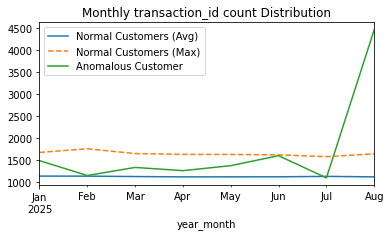

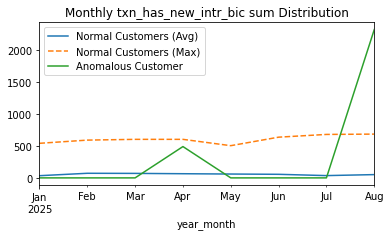

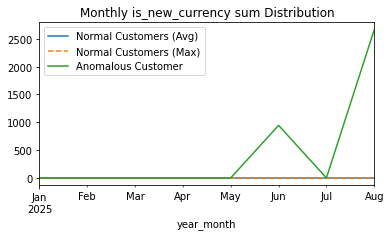

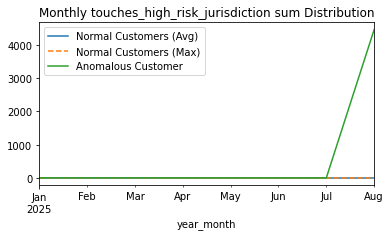

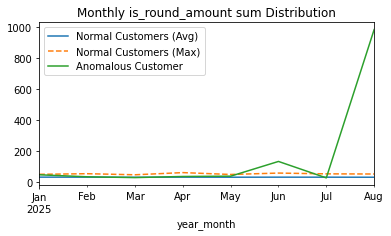

In [16]:
plot_checks(transactions_df, 'transaction_id', 'count')
plot_checks(transactions_df, 'txn_has_new_intr_bic', 'sum')
plot_checks(transactions_df, 'is_new_currency', 'sum')
plot_checks(transactions_df, 'touches_high_risk_jurisdiction', 'sum')
plot_checks(transactions_df, 'is_round_amount', 'sum')

In [ ]:
#from domains.demo_nested_banking.datasets.transactions import transactions_dataset as dataset
#transactions_df = dataset_functions.read(context, dataset().identifier, data_environment=DataEnvironment.PUBLIC).drop('tr_timestamp').toPandas()

In [18]:
aggregated_df = aggregate_features_mx(transactions_df)
aggregated_df.head()

/tmp/ipykernel_49863/3676178517.py:108: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_monthly_agg)


,customer_id,customer_name,year_month,year_month_str,txn_count,total_amt,avg_amt,new_currency_count,new_intr_bic_txn_count,new_intr_bic_count,...,many_to_one_count,pipe_account_behaviour_score,z_txn_count,z_total_amt,z_new_currency_count,z_new_intr_bic_txn_count,z_new_intr_bic_count,z_new_intr_bic_unique_count,z_high_risk_count,z_round_amount_ratio
0,RESP_000,Mitchell-Warren Bank,2025-01-01,2025-01,1219,2.381596e+08,195372.890705,13,541,541,...,80,0.521346,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,RESP_000,Mitchell-Warren Bank,2025-02-01,2025-02,1290,2.495965e+08,193485.644504,0,0,0,...,80,0.482545,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,RESP_000,Mitchell-Warren Bank,2025-03-01,2025-03,1110,2.175294e+08,195972.437360,0,0,0,...,80,0.485122,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,RESP_000,Mitchell-Warren Bank,2025-04-01,2025-04,1279,2.461142e+08,192427.088436,0,0,0,...,80,0.518779,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,RESP_000,Mitchell-Warren Bank,2025-05-01,2025-05,1227,2.391751e+08,194926.724923,0,0,0,...,80,0.529364,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


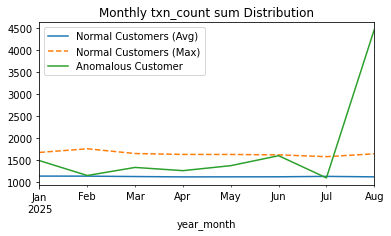

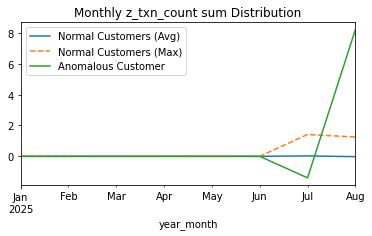

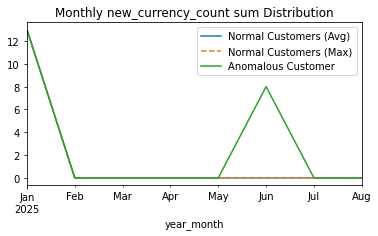

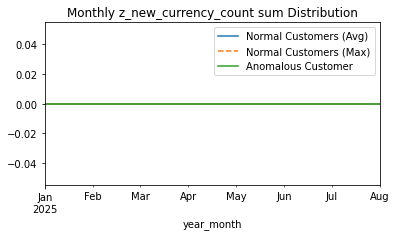

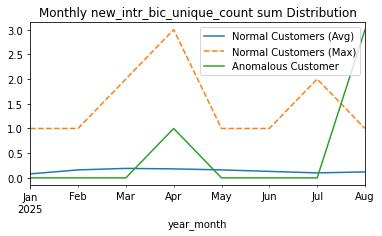

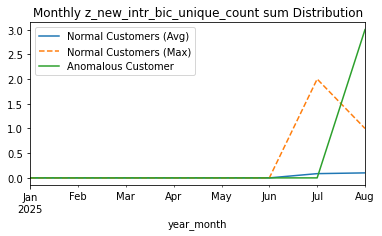

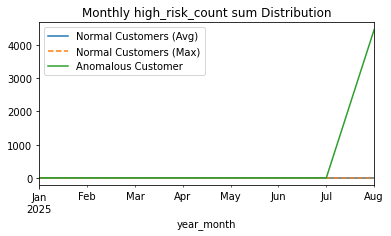

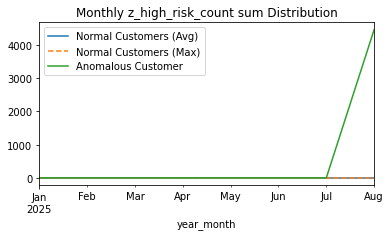

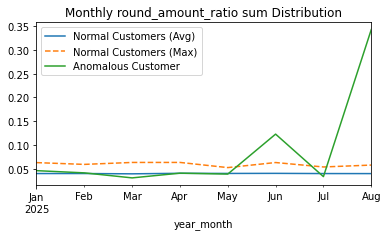

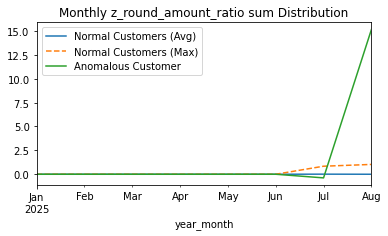

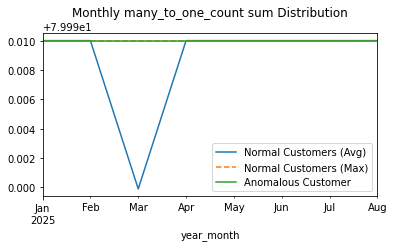

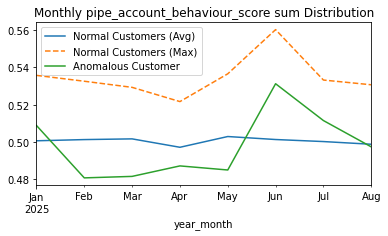

In [19]:
# trigger features
plot_checks(aggregated_df, 'txn_count', 'sum')  # since it's already at customer  and year-month level, param agg does not affect
plot_checks(aggregated_df, 'z_txn_count', 'sum')  # since it's already at customer  and year-month level, param agg does not affect

plot_checks(aggregated_df, 'new_currency_count', 'sum')
plot_checks(aggregated_df, 'z_new_currency_count', 'sum')  # since it's already at customer  and year-month level, param agg does not affect

plot_checks(aggregated_df, 'new_intr_bic_unique_count', 'sum')
plot_checks(aggregated_df, 'z_new_intr_bic_unique_count', 'sum')

plot_checks(aggregated_df, 'high_risk_count', 'sum')
plot_checks(aggregated_df, 'z_high_risk_count', 'sum')

plot_checks(aggregated_df, 'round_amount_ratio', 'sum')
plot_checks(aggregated_df, 'z_round_amount_ratio', 'sum')

# non-trigger features
plot_checks(aggregated_df, 'many_to_one_count', 'sum')
plot_checks(aggregated_df, 'pipe_account_behaviour_score', 'sum')

In [7]:
kyc_df = generate_kyc()
kyc_df

,customer_id,customer_name,nested_account_id,registration_id,swift_bic,incorporation_date,license_type,regulator,head_office_country_code,head_office_country_name,...,sanctions_check_status,ownership_structure,ultimate_beneficial_owner,compliance_officer_assigned,kyc_onboarding_date,kyc_last_review_date,next_review_due,nested_relationship_type,expected_transaction_patterns,monitoring_notes
0,RESP_999,Bank Trust Ltd.,NACC-999999,REG-FI-8636242,UDAXUSRPOIG,1989-11-26,EMI,OCC,US,United States,...,Clear,State-Owned Bank,Shelly Murphy,David Barnes,2013-02-28,2023-12-28,2025-09-11,Direct Nostro/Vostro,Cross-border FI payments; settlement of client...,Subject to enhanced due diligence for USD clea...


In [21]:
dataset_functions.write(context, context.get_spark_session().createDataFrame(aggregated_df), customer_monthly_dataset().identifier, data_environment=DataEnvironment.PUBLIC)
dataset_functions.publish(context, customer_monthly_dataset().identifier, data_environment=DataEnvironment.PUBLIC)

2025-08-27 17:42:47,494:INFO:thetaray.common.logging:### DataSet - writing started ###
2025-08-27 17:42:51,230:INFO:thetaray.common.logging:### DataSet - writing done, 800 written, 0 corrupted, 0 rejected  ###
2025-08-27 17:42:53,788:INFO:thetaray.common.logging:finished publishing records for dataset demo_nested_banking_customer_monthly 


True

In [22]:
dataset_functions.write(context, context.get_spark_session().createDataFrame(transactions_df), transactions_dataset().identifier, data_environment=DataEnvironment.PUBLIC)
dataset_functions.publish(context, transactions_dataset().identifier, data_environment=DataEnvironment.PUBLIC)

2025-08-27 17:42:57,593:INFO:thetaray.common.logging:### DataSet - writing started ###
2025-08-27 17:43:14,215:INFO:thetaray.common.logging:### DataSet - writing done, 908623 written, 0 corrupted, 0 rejected  ###
2025-08-27 17:43:49,515:INFO:thetaray.common.logging:finished publishing records for dataset demo_nested_banking_transactions 


True

In [8]:
dataset_functions.write(context, context.get_spark_session().createDataFrame(kyc_df), customers_dataset().identifier, data_environment=DataEnvironment.PUBLIC)
dataset_functions.publish(context, customers_dataset().identifier, data_environment=DataEnvironment.PUBLIC)

2025-08-27 18:00:04,893:INFO:thetaray.common.logging:### DataSet - writing started ###
2025-08-27 18:00:06,623:INFO:thetaray.common.logging:Partition does not exists, nothing to delete.
2025-08-27 18:00:08,181:INFO:thetaray.common.logging:### DataSet - writing done, 1 written, 0 corrupted, 0 rejected  ###
2025-08-27 18:00:09,511:INFO:thetaray.common.logging:finished publishing records for dataset demo_nested_banking_customers 


True

In [9]:
context.close()